In [1]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..', '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga



Populating the interactive namespace from numpy and matplotlib


### Processing of inDrops data

In [2]:
import misc
data_objs = {}

# This is the object for the inDrops processed data. In the same format as for the Stages 3-6 data. 
s = 'reagg'
data_objs[s] = misc.ReaggComparison('../data/indrops_intermediate')


In [3]:
# %mkdir -pv ../data/quality_filter/*.loom

counts = data_objs[s].counts.values.T
cell_name = data_objs[s].counts.index
# cell_line = np.array([c.split('_')[0] for c in cell_name])
cell_condition = np.array([c.split('_')[0] for c in cell_name])
cell_batch = np.array([c.split('.')[0] for c in cell_name])
gene_name = data_objs[s].counts.columns

min_cells_per_valid_gene = 10

loom_fn = f'../data/quality_filter/reagg.all_cells.raw.loom'
loompy.create(loom_fn, {'': counts},
                  {'Gene': gene_name,
                   '_Valid': (counts.sum(1).A.ravel() > min_cells_per_valid_gene),
                      },
                  {'CellID': cell_name,
                   '_Valid': np.ones(cell_name.shape).astype(int),
                   'CellCondition': cell_condition,
                   'CellBatch': cell_batch,
                      })


In [4]:
loom_fn = f'../data/quality_filter/reagg.all_cells.raw.loom'
ds = loompy.connect(loom_fn)
ds.vals = sp.sparse.csr_matrix(ds.layers[""][:, :])
tds = {'reagg': ds}

In [5]:
seed = 12621154

cga.highvar_pca(ds, ds.vals, namespace='Raw', seed=seed)

ds.ca["RawHighVarTSNE"] = cg.TSNE(perplexity=100).layout(ds.ca[r"RawHighVarPCA"])

In [9]:
cluster_labels = cga.low_qual_cluster_detector(ds, ds.vals)


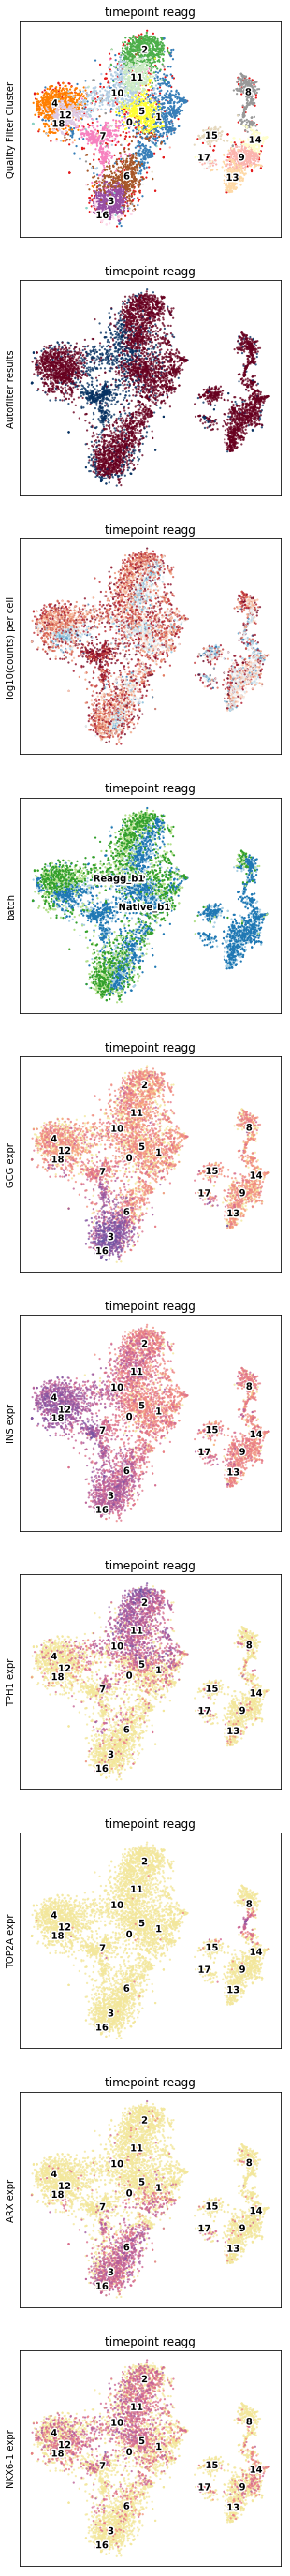

In [5]:
vis.plot_auto_qual_filter_by_time_point(tds, show_genes=['GCG', 'INS', 'TPH1', 'TOP2A', 'ARX', 'NKX6-1'])

In [6]:
manual_changes = defaultdict(lambda : dict(),
                            {'reagg': {'force_false': [], 'force_true': [10,],}})

for tp in tds.keys():
    _tds = tds[tp]
    _tds.ca['__Filter2__Verified_quality'] = cgm.update_cluster_based_filter(
            _tds.ca['__Filter1__Automated_quality'],
            _tds.ca['QualFilterLabels'],
            **manual_changes[tp])

In [7]:
seed = 38172901
for tp in tds.keys():
    _tds = tds[tp]
    
    _train_filter = _tds.ca['__Filter2__Verified_quality'] > 0
    _train_cells = np.where(_train_filter)[0]
    cga.highvar_pca(_tds, _tds.vals, namespace='Final', seed=seed, train_cells=_train_cells, n_highvar_pcs=50)
    
    _tds.ca['__Labels1__Clusters'] = cga.mknn_leiden_labels(_tds.ca['FinalHighVarPCA'][_train_filter], _train_filter,
                           nn_k=100, clustering_resolution=2.0).original

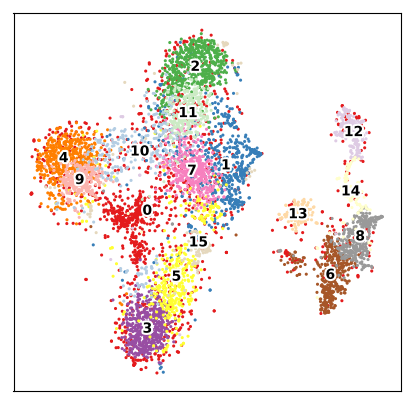

In [8]:

vis.plot_attr_by_time_point(tds, '__Labels1__Clusters', min_elements_for_label=0)


In [10]:
# No need to refine anything

ds.ca["__Labels2__Refined"] = _tds.ca['__Labels1__Clusters']

In [11]:
pb_labels = cgm.CellLabels(_tds.ca['__Labels2__Refined'])
cluster_pseudobulk = cga.pseudobulk_from_label(ds, pb_labels)
cluster_pseudobulk_z = ((cluster_pseudobulk - cluster_pseudobulk.mean())/cluster_pseudobulk.std()).fillna(0.0)
    

In [12]:
autolabel_enrichment = utils.load_df(f'../data/clustering/reagg.autolabels.df.npz')

autolabel_corr = pd.DataFrame(utils.two_array_corr((autolabel_enrichment > 0).astype(float).values,
                                                   cluster_pseudobulk_z.T.loc[autolabel_enrichment.index].values),
                                 columns = autolabel_enrichment.columns,
                                 index=cluster_pseudobulk_z.T.columns)

In [13]:
autolabel_calls = autolabel_corr.idxmax(1)
autolabel_calls = autolabel_calls.to_dict()
autolabel_calls[0] = ''


ann_labels = cgm.CellLabels(np.array([autolabel_calls[li] for li in pb_labels.original]), null_label='')

ds.ca['__Labels3__AnnotatedLabels'] = ann_labels.original

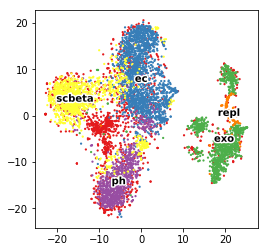

In [16]:
vis.scatter_cat(ds.ca['RawHighVarTSNE'], ds.ca['__Labels3__AnnotatedLabels'] )

In [17]:
classifier_labels = cga.update_labels_with_classifier(ds, ann_labels, seed=58774522, input_space_attr="RawHighVarPCA", 
                                                      recovery_classification_threshold=0.66)

ds.ca['__Labels4__ClassifierLabels_detailed'] = classifier_labels.original
ds.ca['__Labels5__ClassifierLabels'] = np.array([s.split('__')[0] for s in ds.ca['__Labels4__ClassifierLabels_detailed']])

In [18]:
ds.ca['_IsLabelled'] = (ds.ca['__Labels5__ClassifierLabels'] != '').astype(int)

In [19]:
attributes_to_copy = [
    ('CellID', 'CellID'),
    ('CellBatch', 'CellBatch'),
    ('CellCondition', 'CellCondition'),
    ('_Valid', '_Valid'),
    ('__Labels5__ClassifierLabels', 'Labels'),
    ('__Labels4__ClassifierLabels_detailed', 'DetailedLabels'),
    ('_IsLabelled', '_TrainFilter'),
    ]

%rm ../data/complete_processing/reagg.processed.loom
%mkdir ../data/complete_processing/
min_cells_per_valid_gene = 10

new_loom_fn = f'../data/complete_processing/reagg.processed.loom'

f_cells = np.where(ds.ca.__Labels4__ClassifierLabels_detailed != '')[0]
loompy.create(new_loom_fn, {'': ds.vals[:, f_cells]},
              {'Gene': ds.ra.Gene,
               '_Valid': (ds.vals[:, f_cells].sum(1).A.ravel() > min_cells_per_valid_gene)
                  },
              {new_attr_name: ds.ca[old_attr_name][f_cells] for old_attr_name, new_attr_name in attributes_to_copy},
             )


In [ ]:
new_loom_fn = f'../data/complete_processing/reagg.processed.loom'
pds = loompy.connect(new_loom_fn)
pds.vals = sp.sparse.csr_matrix(pds.layers[""][:, :])

In [21]:
full_labels = cgm.CellLabels(pds.ca.Labels, null_label="")
condition_labels = cgm.CellLabels(np.array([f'{cd}__{cl}' for cd,cl in zip(pds.ca.CellCondition, pds.ca.Labels)]), null_label="")

for _labels, label_name in [
                        (full_labels, 'labels'),
                        (condition_labels, 'condition_labels'),]:
    

    tp_pb = cga.pseudobulk_from_label(pds, _labels, norm_total=10**6)
    tp_expr = cga.expressed_fraction_from_label(pds, _labels)
    
    utils.save_df(tp_pb, f'../data/complete_processing/reagg.{label_name}.pseudobulk_tpm.df.npz')
    utils.save_df(tp_expr, f'../data/complete_processing/reagg.{label_name}.expr_frac.df.npz')

In [22]:
cga.highvar_pca(pds, pds.vals, namespace='', seed=3831028, n_highvar_genes=1000)

pds.ca["TSNE"] = cg.TSNE(perplexity=200, max_iter=1000,).layout(pds.ca[r"HighVarPCA"][:,:15])

In [1]:
vis.scatter_cat(pds.ca["TSNE"], ds.ca.Labels)

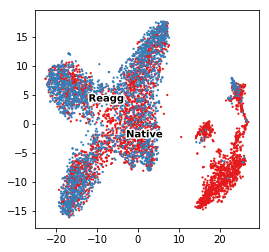

In [115]:
vis.scatter_cat(pds.ca["TSNE"], pds.ca.CellCondition)

In [116]:
pds.close()